#### Import dataset, punctuations and stop words

In [36]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
# Read Train Data
train_df = pd.read_csv('./swad_train.csv', header=0, names = ['id','tweet','label'])
# Convert string labels to numerical labels
train_df.loc[train_df['label']=='Yes',['label']]=1
train_df.loc[train_df['label']=='No',['label']]=0
# Read Test Data
test_df = pd.read_csv('./swad_test.csv', header=0, names = ['id','tweet','label'])
# Convert string labels to numerical labels
test_df.loc[test_df['label']=='Yes',['label']]=1
test_df.loc[test_df['label']=='No',['label']]=0
# Read Punctuations
df_punctuations = pd.read_fwf('./punctuations.txt',header=None,names = ['punctuations'])
puncs = ''.join(df_punctuations['punctuations'])
# Read Stop Words
df_stop_words = pd.read_fwf('./stopwords.txt',header=None,names = ['stopwords'])
stop_words = [x for x in df_stop_words['stopwords']]

In [3]:
class TfIdf(object):

    def __init__(self,):
        self.vocab = {}
        self.df = {}
        self.num_docs = 0

    def preprocess(self, text):
        ''' Pre-Process texts
            Input  : text string
            Output : tokens
        '''
        text = text.strip()
        # lower casing
        text = text.lower()
        # add space before and after punctuations
        text = text.translate(str.maketrans({key: ' {0} '.format(key) for key in puncs}))
        # Tokenize text
        tokens = text.split()
        # Remove Stop words
        tokens = [token for token in tokens if not token in stop_words]
        return tokens

    def fit(self, texts):
        ''' Fit data to TF-IDF model
            Input  : List of Documents
            Output : None
        '''
        self.num_docs=len(texts)

        for text in tqdm(texts, desc='Fitting the Data'):
            tokens = self.preprocess(text)
            # add unique words in vocab
            self.vocab.update({token:0 for token in tokens})
            # get Document Frequency
            self.df.update({token:0 for token in set(tokens) if token not in self.df.keys()})
            self.df.update({token:self.df[token]+1 for token in set(tokens) if token in self.df.keys()})

    def transform(self, texts):
        ''' Transform data to TF-IDF matrix
            Input  : List of Documents
            Output : TF-IDF Matrix
        '''
        tfidf = np.zeros((len(texts), len(self.vocab)))
        for i, text in tqdm(enumerate(texts), desc='Generating TF-IDF Matrix', total=len(texts)):
            tokens = self.preprocess(text)
            # calculate term frequncy
            tf = np.array([tokens.count(word)/len(tokens) for idx,word in enumerate(self.vocab.keys())]).squeeze()
            # calculate inverse document frequency
            idf = np.array([np.log((self.num_docs)/(self.df[word]+1)) for idx,word in enumerate(self.vocab.keys())]).squeeze()
            # calculate tfidf
            tfidf[i] = tf*idf
        return tfidf

In [4]:
tfidf = TfIdf()
tfidf.fit(train_df['tweet'].values.astype(str))

x_train = tfidf.transform(train_df['tweet'].values.astype(str))
x_test = tfidf.transform(test_df['tweet'].values.astype(str))


y_train = np.zeros((train_df['label'].values.astype(int).shape[0], 2))
y_train[np.arange(train_df['label'].values.astype(int).shape[0]), train_df['label'].values.astype(int)] = 1

y_test = np.zeros((test_df['label'].values.astype(int).shape[0], 2))
y_test[np.arange(test_df['label'].values.astype(int).shape[0]), test_df['label'].values.astype(int)] = 1


print('The size of training set:', x_train.shape)
print('The size of test set:', x_test.shape)



Fitting the Data:   0%|          | 0/3589 [00:00<?, ?it/s]

Generating TF-IDF Matrix:   0%|          | 0/3589 [00:00<?, ?it/s]

Generating TF-IDF Matrix:   0%|          | 0/500 [00:00<?, ?it/s]

The size of training set: (3589, 6569)
The size of test set: (500, 6569)


In [5]:
def sigmoid(x):
    x = 1/(1+np.exp(-x))
    return x

class LogisticRegression(object):
    
    def __init__(self,):
        ''' Initialization of the weights and bias '''
        self.w = 0
        self.b = 0
        
    def BCE(self, x, y):
        ''' Calculates the binary cross entropy loss of the model '''
        loss = 0
        z = x @ self.w + self.b
        n = x.shape[0]
        loss = -np.sum(np.sum((y*np.log(sigmoid(z))) + ((1-y) * (np.log(1-sigmoid(z)))),axis=1))/n
        return loss
    
    def predict(self, x):
        ''' Predicts labels for input test data '''
        y_hat = sigmoid(np.dot(x, self.w)+self.b).squeeze()
        return np.argmax(y_hat, axis=-1)

    def fit(self, X, Y, lr, num_epoch=100,print_loss = True):
        ''' Model Training using Stochastic Gradient Descent Optimization'''
        self.w = np.random.rand(X.shape[1], Y.shape[1])
        self.b = np.random.rand(1, Y.shape[1])
        
        # Run Stocahastic Gradient Descent for given iterations
        for e in tqdm(range(num_epoch),desc='Training'):

            for i in range(len(X)):
                # feed one row at a time to the model
                x = X[i,:].reshape(1,-1)
                y = Y[i,:].reshape(1,-1)
                
                # Calculate gradients for the weights and bias
                dw = []
                db = []
                z = x @ self.w + self.b
                dw = x.T @ (sigmoid(z)-y)
                db = sigmoid(z)-y

                # Update weights and Bias
                self.w -= lr*dw
                self.b -= lr*db
    
            if print_loss:
                if (e+1)%50==0 or e ==0:
                    print(f'At epoch {e+1}, loss: {self.BCE(X,Y):.4f}.')
    


In [6]:

epochs = 150
lr = 0.01
LogReg_clf = LogisticRegression()
LogReg_clf.fit(x_train, y_train, lr, epochs)
y_hat = LogReg_clf.predict(x_test)
y = np.argmax(y_test, axis=1)
accuracy_score = 1 - np.sum((y-y_hat)**2)/len(y)

print(f'Test Accuracy : {accuracy_score*100:.4f}% .')


Training:   0%|          | 0/150 [00:00<?, ?it/s]

At epoch 1, loss: 1.3492.
At epoch 50, loss: 0.8302.
At epoch 100, loss: 0.6552.
At epoch 150, loss: 0.5553.
Test Accuracy : 85.0000% .


## Q.2

In [37]:
# Read the data
df = pd.read_csv('./income.csv')
# the column education and education-num are same, so dropping one.
df = df.drop(columns=['education-num'])
categorical_cols = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
numerical_cols = ['age','fnlwgt','capital-gain','capital-loss','hours-per-week']
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [81]:
import matplotlib.pyplot as plt
class KMeans(object):

    def preprocess(self, df,categorical_cols,numerical_cols):
        ''' Pre-Process data
            Input  : data, list of categorical columns, list of numerical columns
            Output : preprocess nd-array
        '''
        
        for col in numerical_cols:
            # Replace unknown values with column mean
            df.loc[df[col]==' ?',[col]]=np.mean(df[col])
            # Normalization
            df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())

        # x = np.array(df.drop(columns=categorical_cols).values.astype(float))
        
        for col in categorical_cols:
            categories = np.unique(df[col])

            # Replace categories with numerical values
            for i,c in enumerate(categories):
                df.loc[df[col]==c,[col]]=i
            
            # # One Hot encoding for categorical values
            # one_hot = np.zeros((df[col].shape[0],len(categories)))
            # one_hot[np.arange(df[col].shape[0]),df[col].values.astype(int)] = 1
            # x = np.concatenate((x,one_hot),axis=1)
        
            
        
        return np.array(df.values.astype(float))
    
    def distance(self,x,c):
        # Initialize dist
        dist = np.zeros((x.shape[0],1))
        # Loop through each centroid
        for centroid in c:
            # calculate distance of centroid from each point
            distc = np.sqrt(np.sum((x-centroid)**2,axis=1)).reshape(-1,1)
            # add distances to an array
            dist = np.concatenate((dist,distc),axis=1)
        # remove column with zero values
        dist = np.delete(dist,0,axis=1)
        return dist
    
    def cluster(self,x,k, num_epochs):
        ''' Clusters data into n clusters
            input: data,num of clusters,num of iterations
            output: labels, distortions
        '''

        ## initialize centroids

        # choosing k random indices from data
        idx = np.random.choice(len(x), k, replace=False)
        # assigning the indices as centroids
        c = x[idx, :]
        # finding the distance between centroids and all the data points
        dist = self.distance(x, c)
        # print(dist.shape)
        # Centroid labels with the minimum Distance drom point i
        labels = np.array([np.argmin(i) for i in dist])
        # print(labels.shape)

        ## Repeating the above steps for the number of epochs
        for _ in range(num_epochs):
            c = []
            for idx in range(k):
                # Updating Centroids by taking mean of Cluster it belongs to
                temp_cent = x[labels==idx].mean(axis=0) 
                c.append(temp_cent)
            c = np.vstack(c) #Updated Centroids 
            dist = self.distance(x, c)
            labels = np.array([np.argmin(i) for i in dist])
        print(f'{k} clusters formed')
        distortions = np.mean(np.min(dist,axis=1))
        
        return distortions
 

    


1 clusters formed
2 clusters formed
3 clusters formed
4 clusters formed
5 clusters formed
6 clusters formed
7 clusters formed
8 clusters formed
9 clusters formed
10 clusters formed


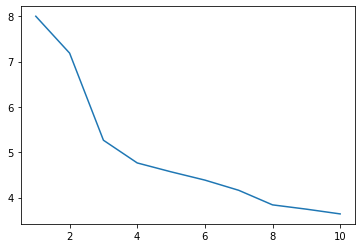

In [83]:
clf = KMeans()
px = clf.preprocess(df,categorical_cols,numerical_cols)

dist = []
ks = []
for k in range(10):
    distortions = clf.cluster(px,k+1,100)
    dist.append(distortions)
    ks.append(k+1)

plot = plt.plot(ks,dist)


### The optimized k Value can be found at K = 3 where we can clearly see the elbow forming

In [13]:
label,d = clf.cluster(px,3,1000)


3 clusters formed


In [17]:
print(d)

5.264737197462814
